In [24]:
import  numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

from pycountry_convert import country_name_to_country_alpha3, country_alpha2_to_country_name

In [25]:
data = pd.read_csv('./data/human_trafficking.csv', low_memory=False)

In [26]:
data.head()

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [27]:
data.replace('-99', np.nan, inplace=True)
data.replace(-99, np.nan, inplace=True)

In [28]:
def get_alpha3(col):
    try:
        iso_3 =  country_name_to_country_alpha3(col)
    except:
        iso_3 = 'Unknown'
    return iso_3

def get_name(col):
    try:
        name =  country_alpha2_to_country_name(col)
    except:
        name = 'Unknown'
    return name

In [29]:
data['countryCitizenship'] = data['citizenship'].apply(lambda x: get_name(x))
data['alpha3Citizenship'] = data['countryCitizenship'].apply(lambda x: get_alpha3(x))

data['CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_name(x))
data['alpha3CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_alpha3(x))

In [30]:
df_origin = pd.DataFrame(data.groupby(['countryCitizenship', 'alpha3Citizenship'])['alpha3Citizenship'].agg(victims='count')).reset_index()

fig = px.choropleth(df_origin, locations="alpha3Citizenship",
                    color="victims",
                    hover_name="countryCitizenship",
                    color_continuous_scale='Viridis_r')
fig.update_layout(title_text="Human Trafficking Victims")
fig.show()

In [31]:
df_destination = pd.DataFrame(data.groupby(['CountryOfExploitation', 'alpha3CountryOfExploitation'])['alpha3CountryOfExploitation'].agg(agresors='count')).reset_index()

fig = px.choropleth(df_destination, locations="alpha3CountryOfExploitation",
                    color="agresors",
                    hover_name="CountryOfExploitation",
                    color_continuous_scale='Viridis_r')
fig.update_layout(title_text="Human Trafficking Victims")
fig.show()

In [37]:
df_origin.rename(columns = {'alpha3Citizenship':'iso3', 'countryCitizenship':'name', 'victims':'Out'}, inplace = True)
df_destination.rename(columns = {'alpha3CountryOfExploitation':'iso3', 'CountryOfExploitation':'name','agresors':'In'}, inplace = True)

df_flow = pd.merge(df_origin, df_destination, how='outer', on=['iso3','name'])
df_flow.replace(np.nan, 1, inplace=True)
df_flow['Human Trafficking Flow'] = df_flow['Out'] - df_flow['In']
df_flow['Human Trafficking Flow (Symmetric Log Scale)'] = np.log(np.abs(df_flow['Out'] - df_flow['In'])) * np.sign(df_flow['Out'] - df_flow['In'])

fig = px.choropleth(df_flow, locations="iso3", color="Human Trafficking Flow (Symmetric Log Scale)", hover_name="name", title = 'Human Trafficking Flow', color_continuous_scale='Viridis_r')
fig.show()

Positive Flow: Origin of Human Trafficking
Negative Flow: Destination of Human Trafficking


In [38]:
data['Victims'] = 1
fig = px.sunburst(data[data.ageBroad.notna()], path=['gender', 'ageBroad'], values='Victims', color='gender',
                  title='Gender and Age of Human Trafficking Victims')
fig.update_layout(width=600, height=600)
fig.show()

In [40]:
data_bar_mg = pd.DataFrame(data.groupby(['gender', 'majorityStatus'])['majorityStatus'].agg(Victims='count')).reset_index()

fig = px.bar(data_bar_mg, x="majorityStatus", y="Victims", color="gender", 
            title="Majority and Gender of Human Trafficking Victims",
            labels={'majorityStatus':'Majority Status'})
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(hovermode='x')
fig.show()

In [41]:
data['meansOfControlConcatenated'] = data['meansOfControlConcatenated'].str.replace('Abuse', 'abuse', regex=True)
data_bar_f = data[(data.meansOfControlConcatenated.notna()) & (data.gender == 'Female')].meansOfControlConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
data_bar_m = data[(data.meansOfControlConcatenated.notna()) & (data.gender == 'Male')].meansOfControlConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(hovermode='x', title_text='Means of Control')
fig.show()

In [42]:
data_bar_f = data[(data.typeOfExploitConcatenated.notna()) & (data.gender == 'Female')].typeOfExploitConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
data_bar_m = data[(data.typeOfExploitConcatenated.notna()) & (data.gender == 'Male')].typeOfExploitConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(title_text='Type of Exploit')
fig.show()

In [43]:
data_bar_f = data[(data.RecruiterRelationship.notna()) & (data.gender == 'Female')].RecruiterRelationship.apply(lambda x: pd.value_counts(str(x).split("; "))).sum(axis = 0)
data_bar_m = data[(data.RecruiterRelationship.notna()) & (data.gender == 'Male')].RecruiterRelationship.apply(lambda x: pd.value_counts(str(x).split("; "))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(title_text='Recruiter Relationship')
fig.show()

<AxesSubplot:xlabel='index', ylabel='yearOfRegistration'>

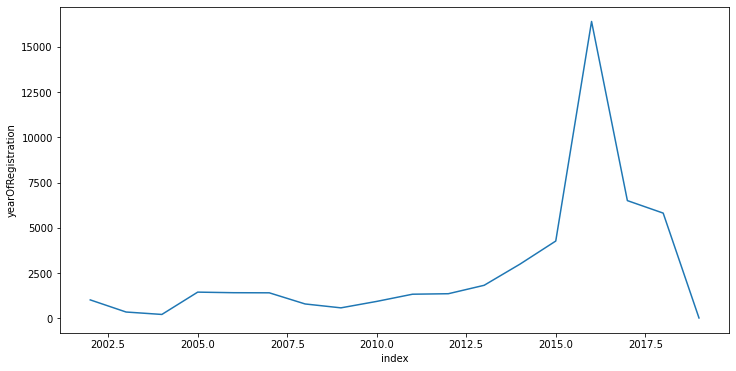

In [60]:
count_by_years = data['yearOfRegistration'].value_counts().reset_index().sort_values('index')

fig = plt.figure(figsize=(12,6))
sns.lineplot(x=count_by_years['index'], y=count_by_years.yearOfRegistration)